<a href="https://colab.research.google.com/github/peddlem25/deepmind-research/blob/master/3d_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playing around with Google DeepMind 3D shapes

This repository contains the 3D shapes dataset, used in Kim, Hyunjik and Mnih, Andriy. "Disentangling by Factorising." In Proceedings of the 35th International Conference on Machine Learning (ICML). 2018. to assess the disentanglement properties of unsupervised learning methods.

Data set provided by: 

* @misc{3dshapes18,
* title={3D Shapes Dataset},
* author={Burgess, Chris and Kim, Hyunjik},
* howpublished={https://github.com/deepmind/3dshapes-dataset/},
* year={2018}}

# About

3dshapes is a dataset of 3D shapes procedurally generated from 6 ground truth independent latent factors. These factors are floor colour, wall colour, object colour, scale, shape and orientation.

All possible combinations of these latents are present exactly once, generating N = 480000 total images.

## Latent factor values

* floor hue: 10 values linearly spaced in [0, 1]
* wall hue: 10 values linearly spaced in [0, 1]
* object hue: 10 values linearly spaced in [0, 1]
* scale: 8 values linearly spaced in [0, 1]
* shape: 4 values in [0, 1, 2, 3]
* orientation: 15 values linearly spaced in [-30, 30]
* We varied one latent at a time (starting from orientation, then shape, etc), and sequentially stored the images in fixed order in the images array. The 
* corresponding values of the factors are stored in the same order in the labels array.

The data is stored in a HDF5 file with the following fields:

images: (480000 x 64 x 64 x 3, uint8) RGB images.
labels: (480000 x 6, float64) Values of the latent factors.


In [0]:
# Import
from matplotlib import pyplot as plt
import numpy as np
import h5py

In [13]:
# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

KeysView(<HDF5 file "3dshapes.h5" (mode r)>)


**Methods for sampling unconditionally/conditionally on a given factor**

In [0]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """
  indices = np.random.choice(n_samples, batch_size)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

In [0]:
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

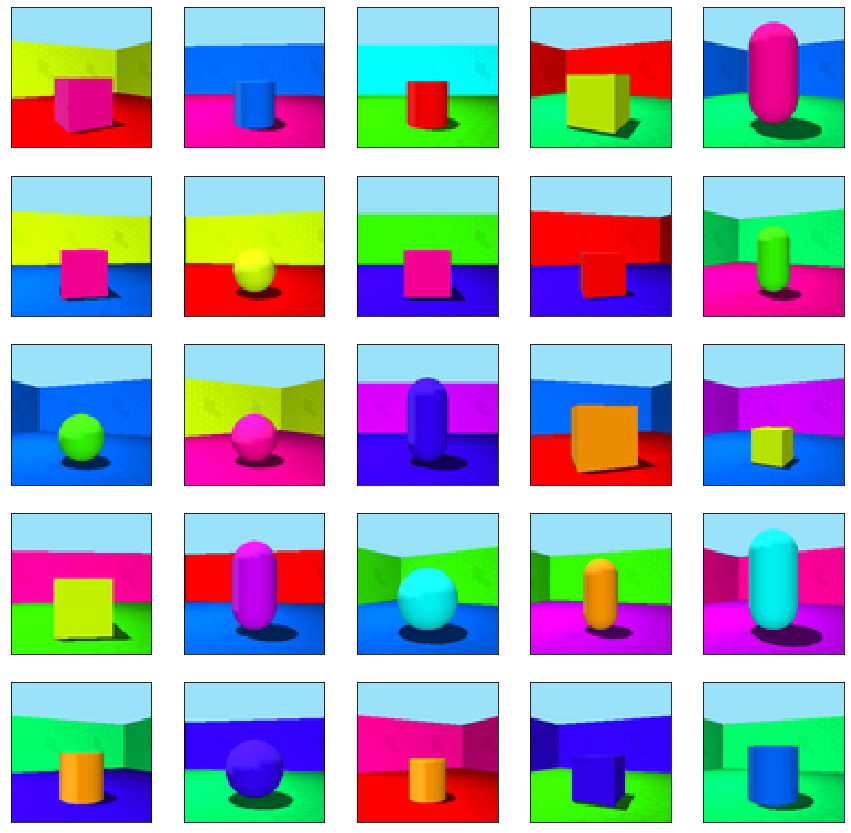

In [16]:
# Examples
batch_size = 25
img_batch = sample_random_batch(batch_size)

show_images_grid(img_batch)

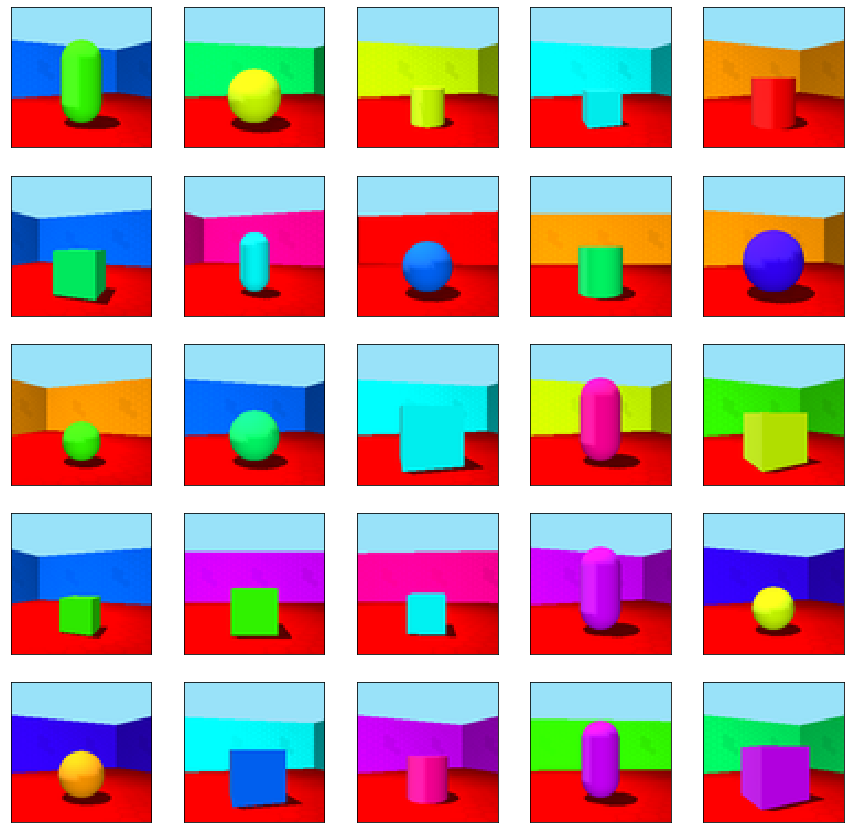

In [17]:
#more
batch_size = 25
fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 0  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

show_images_grid(img_batch)

Tested by: Matt Peddle Jan 27, 2020